In [1]:
import os
from tqdm import tqdm_notebook as tqdm
import glob
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.pyplot import imread
import pandas as pd

In [4]:
def mean_img(df, action, w, h, num_samples=10):
    actions = df[df['shape'] == action]
    paths = actions['output_path']
    imgs = np.empty((num_samples, h, w, 3))
    for i, path in enumerate(paths):
        imgs[i] = imread(path)
    plt.imshow(imgs.mean(axis=0) / 255)

In [2]:
data = [
    (
        '/Users/mchrusci/uj/shaper/data/mountains/mountains.jpg', 
        '/Users/mchrusci/uj/shaper/result/evolution-strategies-experiments/{}/mountains/mountains-run-{}-%d.jpg'
    ), (
        '/Users/mchrusci/uj/shaper/data/city.jpg',
        '/Users/mchrusci/uj/shaper/result/evolution-strategies-experiments/{}/city/city-run-{}-%d.jpg'
    ), (
        '/Users/mchrusci/uj/shaper/data/tree/tree-small.jpg',
        '/Users/mchrusci/uj/shaper/result/evolution-strategies-experiments/{}/tree/tree-run-{}-%d.jpg'
    )
]

# Random strategy

Wszystkie runy odpalane z parametrami:
* random = 100
* sample = 20
* step = 50

10 runów na 3 obrazkach

In [29]:
NUM_RUNS = 10
NUM_ACTIONS = 100
ALGORITHM = 'random'

for inpt, output in tqdm(data[1:]):
    for run in tqdm(range(NUM_RUNS)):
        cmd = f'python ../main.py --input {inpt} --output {output.format(ALGORITHM, run)} --n {NUM_ACTIONS} ' \
              f'--algorithm {ALGORITHM}'
        os.system(cmd)

# Simple evolution strategy

Wszystkie runy odpalane z parametrami:
* random = 100
* sample = 20
* step = 50

10 runów na 3 obrazkach, każdy run z inną wartością sigma

In [7]:
data = [
    (
        '/Users/mchrusci/uj/shaper/data/mountains/mountains.jpg', 
        '/Users/mchrusci/uj/shaper/result/evolution-strategies-experiments/{}/mountains/mountains-run-{}-sigma-{}-%d.jpg'
    ), (
        '/Users/mchrusci/uj/shaper/data/city.jpg',
        '/Users/mchrusci/uj/shaper/result/evolution-strategies-experiments/{}/city/city-run-{}-sigma-{}-%d.jpg'
    ), (
        '/Users/mchrusci/uj/shaper/data/tree/tree-small.jpg',
        '/Users/mchrusci/uj/shaper/result/evolution-strategies-experiments/{}/tree/tree-run-{}-sigma-{}-%d.jpg'
    )
]

In [8]:
NUM_RUNS = 1
NUM_ACTIONS = 100
ALGORITHM = 'simple'
NUM_SIGMAS = 10
sigmas = np.linspace(0.01, 0.1, NUM_SIGMAS)
print(sigmas)

[0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1 ]


In [21]:
for inpt, output in tqdm(data):
    for sigma in tqdm(sigmas):
        for run in range(NUM_RUNS):
            cmd = f'python ../main.py --input {inpt} --output {output.format(ALGORITHM, run, str(sigma)[:4])} --n {NUM_ACTIONS} ' \
                  f'--algorithm {ALGORITHM} --sigma-factor {sigma:.2f}'
            os.system(cmd)

# Natural evolution strategy

Wszystkie runy odpalane z parametrami:
* random = 100
* sample = 20
* step = 50

70 runów na 3 obrazkach, (7 optimizerów x 10 lr)

In [23]:
data = [
    (
        '/Users/mchrusci/uj/shaper/data/mountains/mountains.jpg', 
        '/Users/mchrusci/uj/shaper/result/evolution-strategies-experiments/{}/mountains/mountains-run-{}-optimizer-{}-lr-{}-%d.jpg'
    ), (
        '/Users/mchrusci/uj/shaper/data/city.jpg',
        '/Users/mchrusci/uj/shaper/result/evolution-strategies-experiments/{}/city/city-run-{}-optimizer-{}-lr-{}-%d.jpg'
    ), (
        '/Users/mchrusci/uj/shaper/data/tree/tree-small.jpg',
        '/Users/mchrusci/uj/shaper/result/evolution-strategies-experiments/{}/tree/tree-run-{}-optimizer-{}-lr-{}-%d.jpg'
    )
]

In [13]:
NUM_RUNS = 1
NUM_ACTIONS = 100
ALGORITHM = 'natural'
NUM_LR = 10
lrs = np.logspace(-2, 1, num=NUM_LR)
print(lrs)
optimizers = ['sgd', 'momentum', 'nesterov', 'adagrad', 'rmsprop', 'adadelta', 'adam']

[ 0.01        0.02154435  0.04641589  0.1         0.21544347  0.46415888
  1.          2.15443469  4.64158883 10.        ]


In [30]:
for inpt, output in tqdm(data):
    for optimizer in tqdm(optimizers):
        for lr in lrs:
            for run in range(NUM_RUNS):
                cmd = f'python ../main.py --input {inpt} --output {output.format(ALGORITHM, run, optimizer, str(lr)[:4])} --n {NUM_ACTIONS} ' \
                      f'--algorithm {ALGORITHM} --learning-rate {lr:.2f} --optimizer {optimizer} --sigma-factor 0.03'
                os.system(cmd)

In [20]:
# wyniki z plików .npy do jednego csv
RESULTS = '/Users/mchrusci/uj/shaper/result/evolution-strategies-experiments'
CSV = os.path.join(RESULTS, 'scores.csv')

In [ ]:
with open(CSV, "a") as scores:
    scores.write("algorithm,img,optimizer,lr,shape,sigma,mse,output_path\n")

In [55]:
algorithms = ['natural', 'random', 'simple']
imgs = ['city', 'mountains', 'tree']

with open(CSV, "a") as csv:
    for algorithm in algorithms:
        for img in imgs:
            score_paths = glob.glob(os.path.join(RESULTS, algorithm, img, '*scores.npy'))
            if algorithm == 'natural':
                for score in score_paths:
                    optimizer = score.split('optimizer-')[1].split('-lr')[0]
                    lr = score.split('lr-')[1].split('-scores')[0]
                    sigma = ''
                    params = f'{algorithm},{img},{optimizer},{float(lr)},%d,{sigma},%f,%s\n'
                    scores = np.load(score)
                    for n, s in enumerate(scores):
                        output_path = f'{score[:-10]}{n}.jpg'
                        csv.write(params % (n, s, output_path))
            elif algorithm == 'random':
                for score in score_paths:
                    optimizer = ''
                    lr = ''
                    sigma = ''
                    params = f'{algorithm},{img},{optimizer},{lr},%d,{sigma},%f,%s\n'
                    scores = np.load(score)
                    for n, s in enumerate(scores):
                        output_path = f'{score[:-10]}{n}.jpg'
                        csv.write(params % (n, s, output_path))
            else:
                for score in score_paths:
                    optimizer = ''
                    lr = ''
                    sigma = score.split('sigma-')[1].split('-scores')[0]
                    params = f'{algorithm},{img},{optimizer},{lr},%d,{float(sigma)},%f,%s\n'
                    scores = np.load(score)
                    for n, s in enumerate(scores):
                        output_path = f'{score[:-10]}{n}.jpg'
                        csv.write(params % (n, s, output_path))

In [21]:
df = pd.read_csv(CSV)

## Random strategy

In [22]:
all_images = df[df['algorithm'] == 'random']
city = all_images[all_images['img'] == 'city']
mountains = all_images[all_images['img'] == 'mountains']
tree = all_images[all_images['img'] == 'tree']

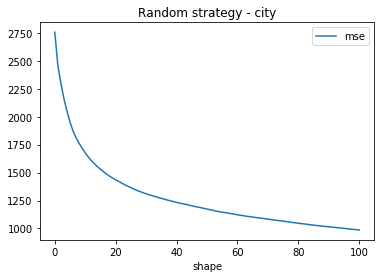

In [113]:
city[['shape', 'mse']].groupby(['shape']).mean().plot(title='Random strategy - city')

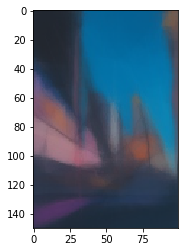

In [117]:
mean_img(df=city, action=100, w=100, h=150)

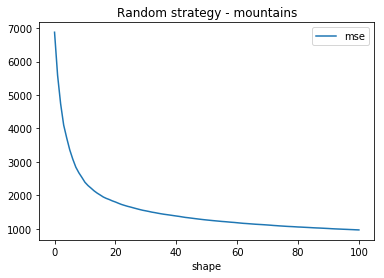

In [120]:
mountains[['shape', 'mse']].groupby(['shape']).mean().plot(title='Random strategy - mountains')

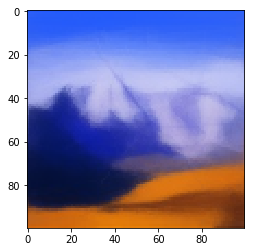

In [121]:
mean_img(df=mountains, action=100, w=100, h=100)

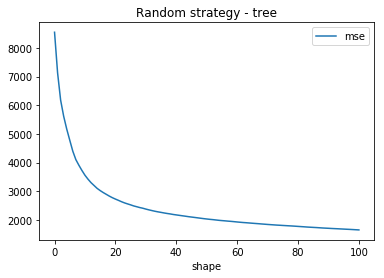

In [122]:
tree[['shape', 'mse']].groupby(['shape']).mean().plot(title='Random strategy - tree')

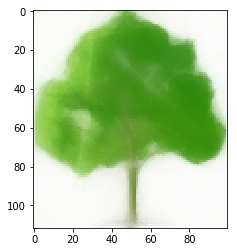

In [127]:
mean_img(df=tree, action=100, w=100, h=112)

### Najlepsze vs najgorsze obrazki wizualnie

In [19]:
def show_best_img(df, n=100):
    x = df[['shape', 'mse', 'output_path']]
    path = x[x['shape'] == n].min()['output_path']
    img = imread(path)
    plt.imshow(img)
    
def show_worst_img(df, n=100):
    x = df[['shape', 'mse', 'output_path']]
    path = x[x['shape'] == n].max()['output_path']
    img = imread(path)
    plt.imshow(img)

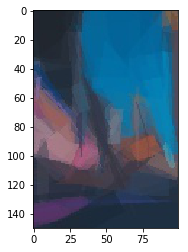

In [107]:
show_best_img(city)

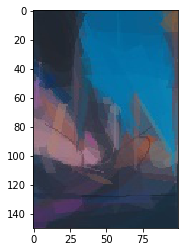

In [108]:
show_worst_img(city)

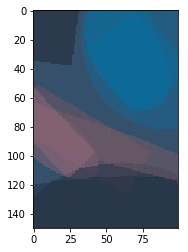

In [23]:
show_best_img(city, n=10)

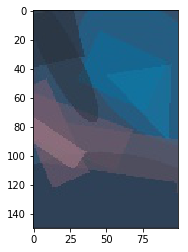

In [24]:
show_worst_img(city, n=10)

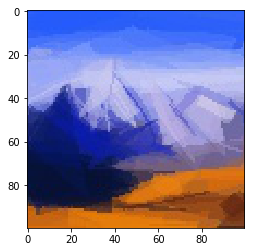

In [109]:
show_best_img(mountains)

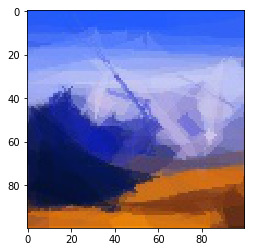

In [27]:
show_worst_img(mountains)

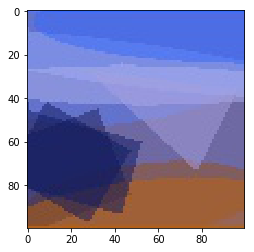

In [28]:
show_best_img(mountains, n=10)

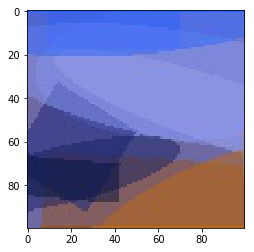

In [26]:
show_worst_img(mountains, n=10)

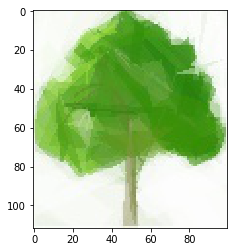

In [111]:
show_best_img(tree)

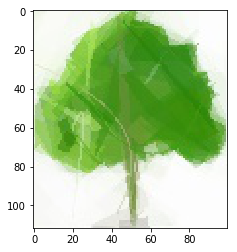

In [30]:
show_worst_img(tree)

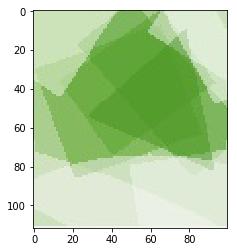

In [31]:
show_best_img(tree, n=10)

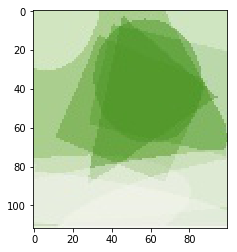

In [32]:
show_worst_img(tree, n=10)

Różnice pomiędzy najlepszymi a najgorszymi obrazkami są bardziej widoczne przy mniejszej ilości akcji (przy drzewie to dobrze widać)

## Simple evolution strategy

In [34]:
all_images = df[df['algorithm'] == 'simple']
city = all_images[all_images['img'] == 'city']
mountains = all_images[all_images['img'] == 'mountains']
tree = all_images[all_images['img'] == 'tree']

In [35]:
def plot_simple(df, name):
    df[['shape', 'sigma', 'mse']].groupby(['shape', 'sigma']).mean().unstack().plot(y='mse', title=f'Simple strategy - {name}')
    
def plot_sigmas(df, name):
    df[['shape', 'sigma', 'mse']].groupby(['sigma']).sum()['mse'].plot(title=f'Simple strategy - {name}, sigmas mse sum')

def show_for_sigma(df, sigma, n=100):
    path = df[(df['sigma'] == sigma) & (df['shape'] == n)]['output_path'].iloc[0]
    img = imread(path)
    plt.imshow(img)

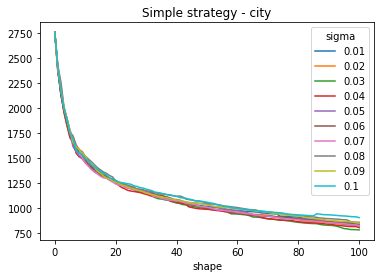

In [171]:
plot_simple(city, 'city')

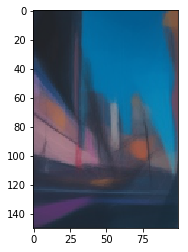

In [158]:
mean_img(df=city, action=100, w=100, h=150)

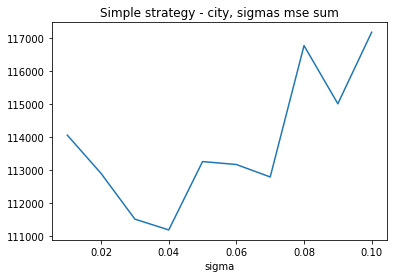

In [177]:
plot_sigmas(city, 'city')

best sigma = 0.04
worst sigma = 0.1

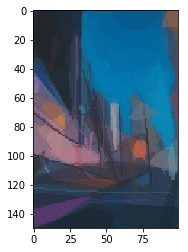

In [117]:
# najlepsza sigma
show_for_sigma(city, 0.04)

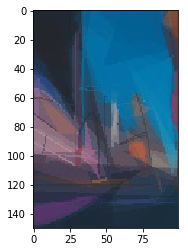

In [118]:
# najgorsza sigma
show_for_sigma(city, 0.1)

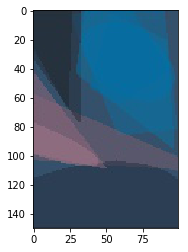

In [36]:
# najlepsza sigma
show_for_sigma(city, 0.04, n=10)

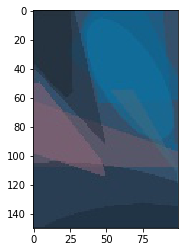

In [37]:
# najgorsza sigma
show_for_sigma(city, 0.1, n=10)

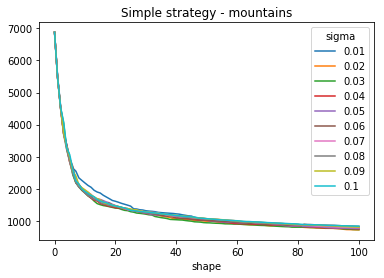

In [178]:
plot_simple(mountains, 'mountains')

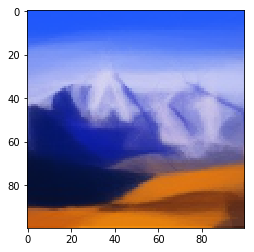

In [179]:
mean_img(df=mountains, action=100, w=100, h=100)

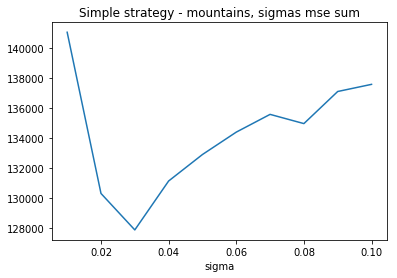

In [180]:
plot_sigmas(mountains, 'mountains')

best sigma = 0.03
worst sigma = 0.01

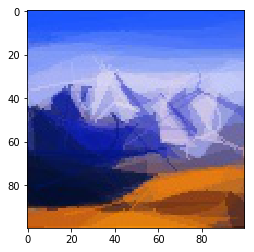

In [119]:
# najlepsza sigma
show_for_sigma(mountains, 0.03)

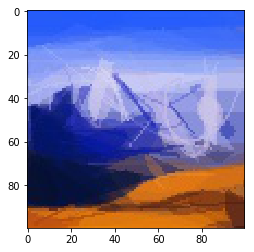

In [120]:
# najgorsza sigma
show_for_sigma(mountains, 0.01)

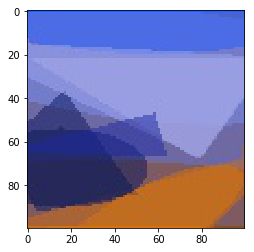

In [38]:
# najlepsza sigma
show_for_sigma(mountains, 0.03, n=10)

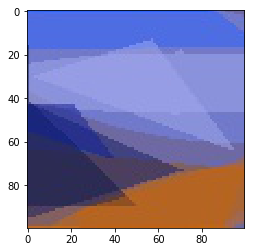

In [39]:
# najgorsza sigma
show_for_sigma(mountains, 0.01, n=10)

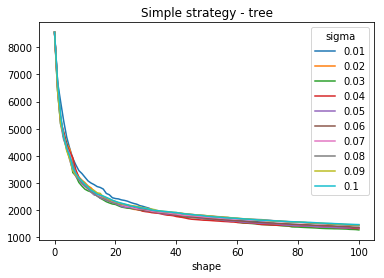

In [181]:
plot_simple(tree, 'tree')

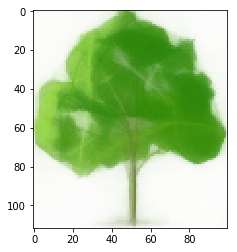

In [182]:
mean_img(df=tree, action=100, w=100, h=112)

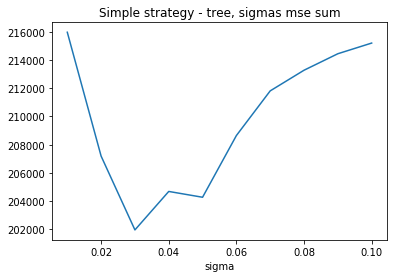

In [183]:
plot_sigmas(tree, 'tree')

best sigma = 0.03
worst sigma = 0.01

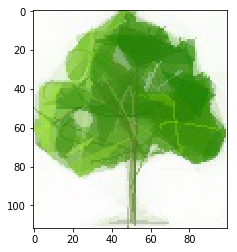

In [122]:
# najlepsza sigma
show_for_sigma(tree, 0.03)

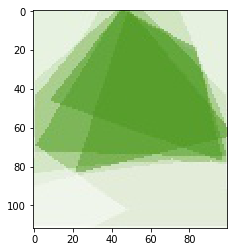

In [40]:
# najlepsza sigma
show_for_sigma(tree, 0.03, n=10)

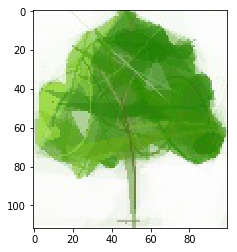

In [123]:
# najgorsza sigma
show_for_sigma(tree, 0.01)

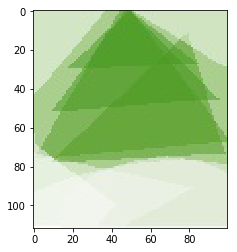

In [41]:
# najgorsza sigma
show_for_sigma(tree, 0.01, n=10)

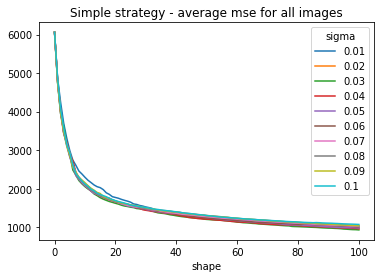

In [185]:
plot_simple(random, 'average mse for all images')

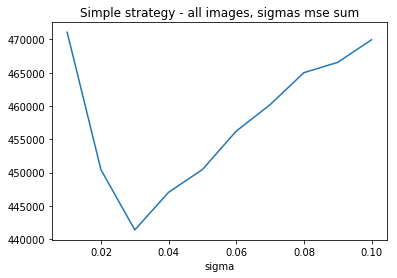

In [187]:
plot_sigmas(random, 'all images')

Najlepsza sigma = 0.03

## Natural evolution strategies

In [42]:
all_images = df[df['algorithm'] == 'natural']
city = all_images[all_images['img'] == 'city']
mountains = all_images[all_images['img'] == 'mountains']
tree = all_images[all_images['img'] == 'tree']

In [43]:
def plot_natural(df, name, optimizer=None):
    if optimizer is None:
        df[['shape', 'optimizer', 'mse']].groupby(['shape', 'optimizer']).mean().unstack().plot(y='mse', title=f'Natural evolution strategy - {name}')
    else:
        x = df[['shape', 'optimizer', 'mse', 'lr']]
        x[x['optimizer'] == optimizer].groupby(['shape', 'lr']).mean().unstack().plot(y='mse', title=f'Natural evolution strategy - {name} ({optimizer})')
    
def plot_optimizers(df, name):
    df[['shape', 'optimizer', 'mse']].groupby(['optimizer']).sum()['mse'].plot.bar(title=f'Natural evolution - {name}, optimizers mse sum')
    
def plot_lr(df, name):
    df[['shape', 'optimizer', 'mse', 'lr']].groupby(['lr', 'optimizer']).sum()['mse'].unstack().plot(title=f'Natural evolution - {name}, lr mse sum')
    
def best_lr(df):
    return df[['shape', 'optimizer', 'mse', 'lr']].groupby(['lr', 'optimizer']).sum()['mse'].argmin()

def worst_lr(df):
    return df[['shape', 'optimizer', 'mse', 'lr']].groupby(['lr', 'optimizer']).sum()['mse'].argmax()

def show_for_optimizer_and_lr(df, optimizer, lr, n=100):
    path = df[(df['optimizer'] == optimizer) & (df['lr'] == lr) & (df['shape'] == n)]['output_path'].iloc[0]
    img = imread(path)
    plt.imshow(img)

### Optimizers

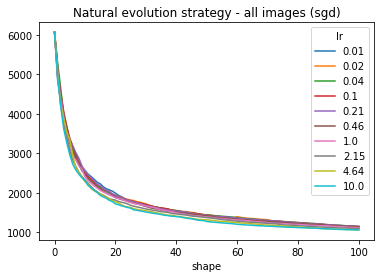

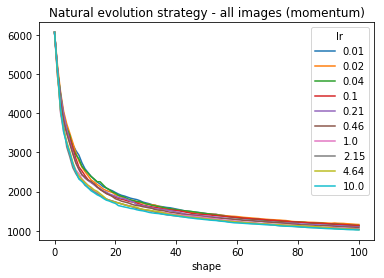

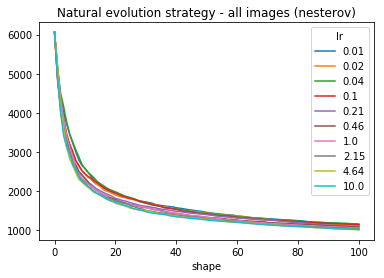

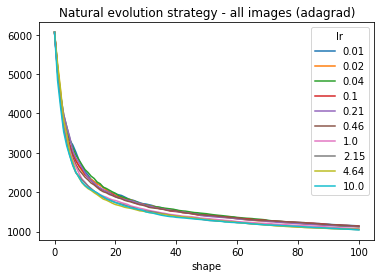

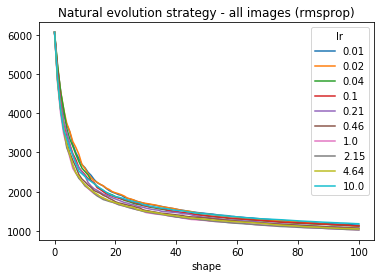

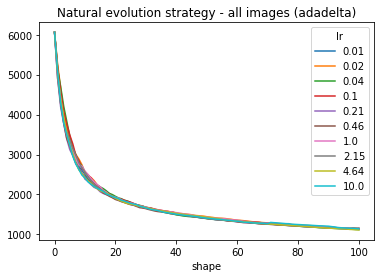

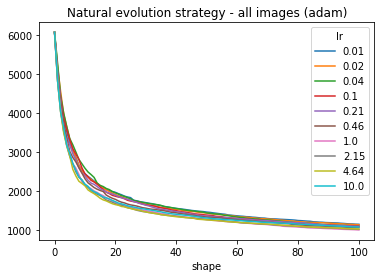

In [23]:
for optimizer in optimizers:
    plot_natural(all_images, 'all images', optimizer)

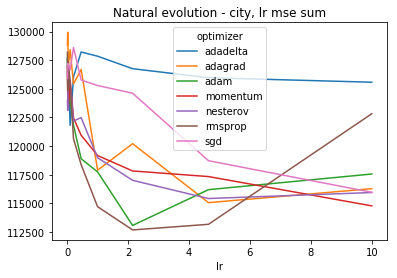

In [39]:
plot_lr(city, 'city')

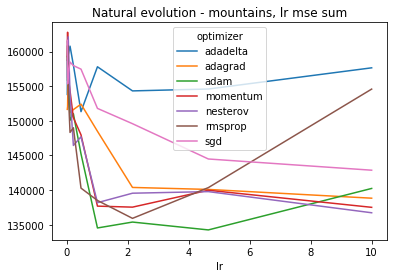

In [40]:
plot_lr(mountains, 'mountains')

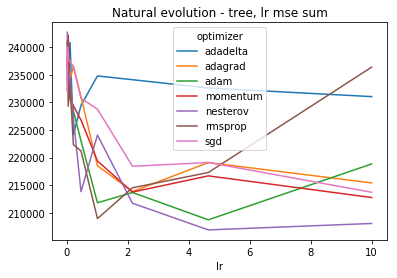

In [42]:
plot_lr(tree, 'tree')

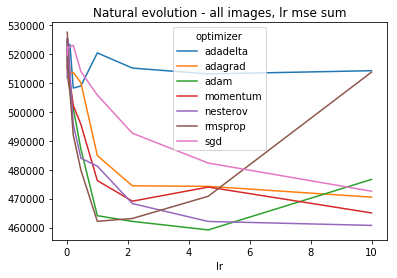

In [41]:
plot_lr(all_images, 'all images')

### Najlepszy optimizer & lr

In [52]:
for df in [all_images, city, mountains, tree]:
    print(best_lr(df))

(4.64, 'adam')
(2.15, 'rmsprop')
(4.64, 'adam')
(4.64, 'nesterov')


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.
  from ipykernel import kernelapp as app


### Najgorszy optimizer & lr

In [53]:
for df in [all_images, city, mountains, tree]:
    print(worst_lr(df))

(0.01, 'rmsprop')
(0.02, 'adagrad')
(0.02, 'momentum')
(0.01, 'nesterov')


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.


### Najlepszy optimizer vs najgorszy optimizer wizualnie

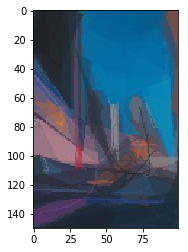

In [71]:
# najlepszy optimizer
show_for_optimizer_and_lr(city, 'rmsprop', 2.15)

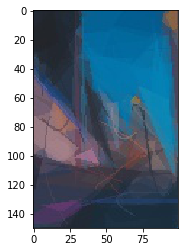

In [72]:
# najgorszy optimizer
show_for_optimizer_and_lr(city, 'adagrad', 0.02)

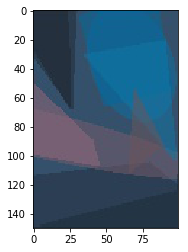

In [44]:
# najlepszy optimizer
show_for_optimizer_and_lr(city, 'rmsprop', 2.15, n=10)

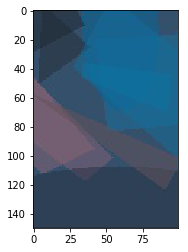

In [45]:
# najgorszy optimizer
show_for_optimizer_and_lr(city, 'adagrad', 0.02, n=10)

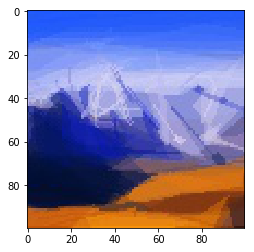

In [73]:
# najlepszy optimizer
show_for_optimizer_and_lr(mountains, 'adam', 4.64)

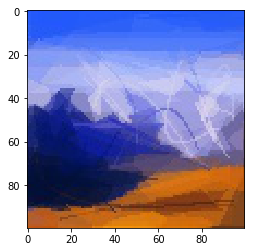

In [77]:
# najgorszy optimizer
show_for_optimizer_and_lr(mountains, 'momentum', 0.02)

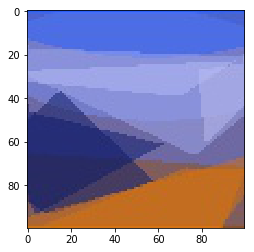

In [46]:
# najlepszy optimizer
show_for_optimizer_and_lr(mountains, 'adam', 4.64, n=10)

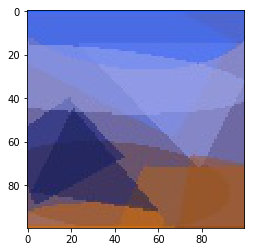

In [47]:
# najgorszy optimizer
show_for_optimizer_and_lr(mountains, 'momentum', 0.02, n=10)

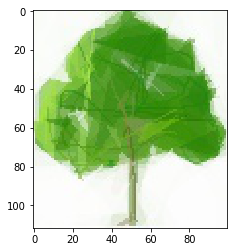

In [78]:
# najlepszy optimizer
show_for_optimizer_and_lr(tree, 'nesterov', 4.64)

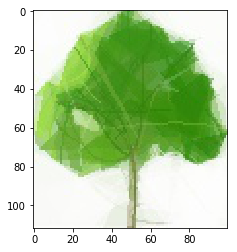

In [79]:
# najgorszy optimizer
show_for_optimizer_and_lr(tree, 'nesterov', 0.01)

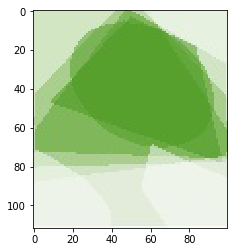

In [48]:
# najlepszy optimizer
show_for_optimizer_and_lr(tree, 'nesterov', 4.64, n=10)

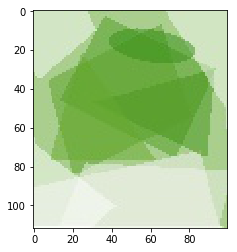

In [49]:
# najgorszy optimizer
show_for_optimizer_and_lr(tree, 'nesterov', 0.01, n=10)

Różnice pomiędzy poszczególnymi optimizerami i lr nie są zbyt duże pod względem wizualnym (pod względem mse też zresztą nie ma powalających różnic)

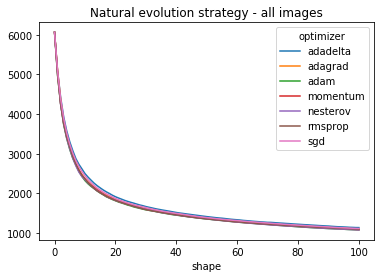

In [80]:
plot_natural(all_images, 'all images')

### Średnie obrazki

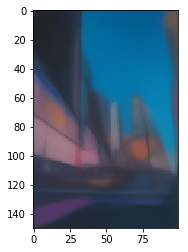

In [81]:
mean_img(df=city, action=100, w=100, h=150, num_samples=70)

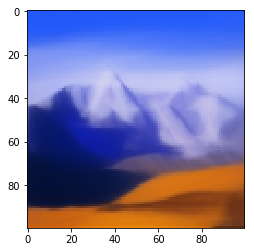

In [82]:
mean_img(df=mountains, action=100, w=100, h=100, num_samples=70)

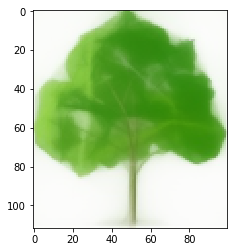

In [83]:
mean_img(df=tree, action=100, w=100, h=112, num_samples=70)

# Wnioski

W przypadku wszystkich trzech algorytmów wyszło plus minus, że parametry zbytnio nie wpływają na końcowy efekt wizualny - obrazki "najgorsze" pod kątem mse nie różnią się bardzo od tych "najlepszych" i w pewnym przypadkach nawet ciężko jest stwierdzić, który jest tym lepszy, a który tym gorszym

# Porównanie algorytmów

Dla random strategy średnia z wszystkich runów  
Dla simple evolution strategy run z sigmą = 0.03   
Dla natural evolution strategy run z sigmą = 0.03, adamem i lr = 4.64

## Score

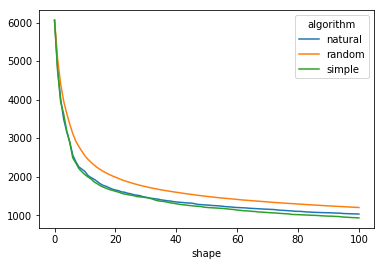

In [156]:
df[(df['algorithm'] == 'random') | ((df['algorithm'] == 'simple') & (df['sigma'] == 0.03)) | ((df['algorithm'] == 'natural') & (df['optimizer'] == 'adam') & (df['lr'] == 4.64))][['shape', 'mse', 'algorithm']].groupby(['shape', 'algorithm']).mean()['mse'].unstack().plot()

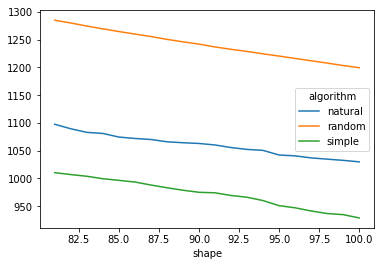

In [158]:
df[(df['shape'] > 80) & ((df['algorithm'] == 'random') | ((df['algorithm'] == 'simple') & (df['sigma'] == 0.03)) | ((df['algorithm'] == 'natural') & (df['optimizer'] == 'adam') & (df['lr'] == 4.64)))][['shape', 'mse', 'algorithm']].groupby(['shape', 'algorithm']).mean()['mse'].unstack().plot()

## Średnie obrazki
W kolejności random, simple, natural

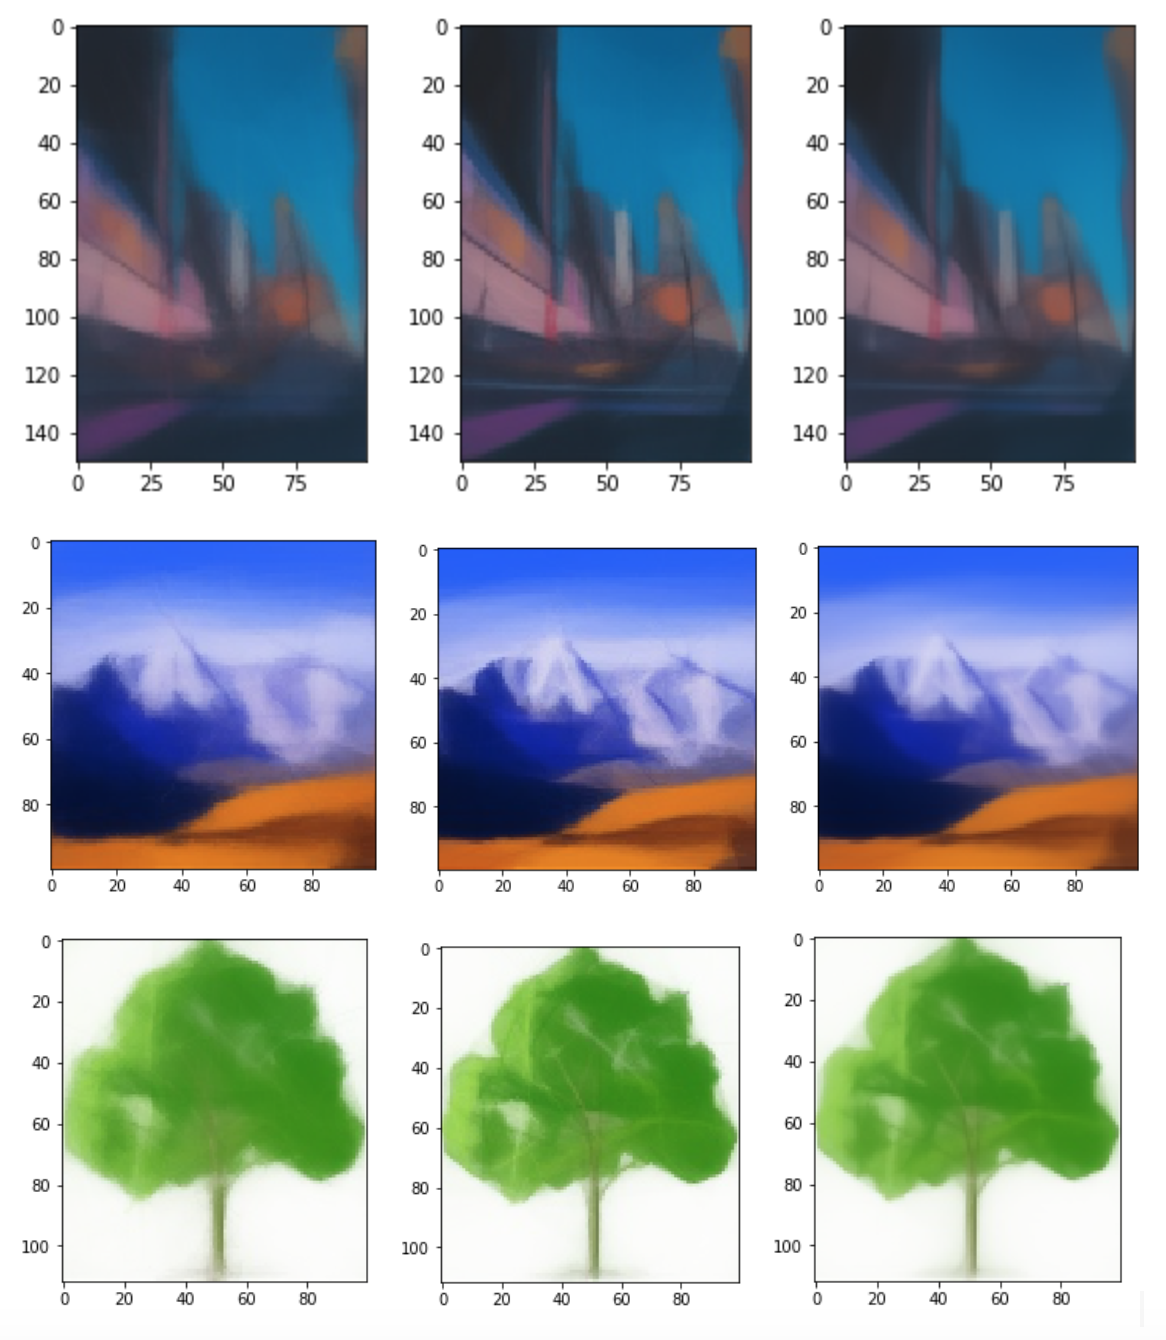

## Najlepsze obrazki n = 100
W kolejności random, simple, natural

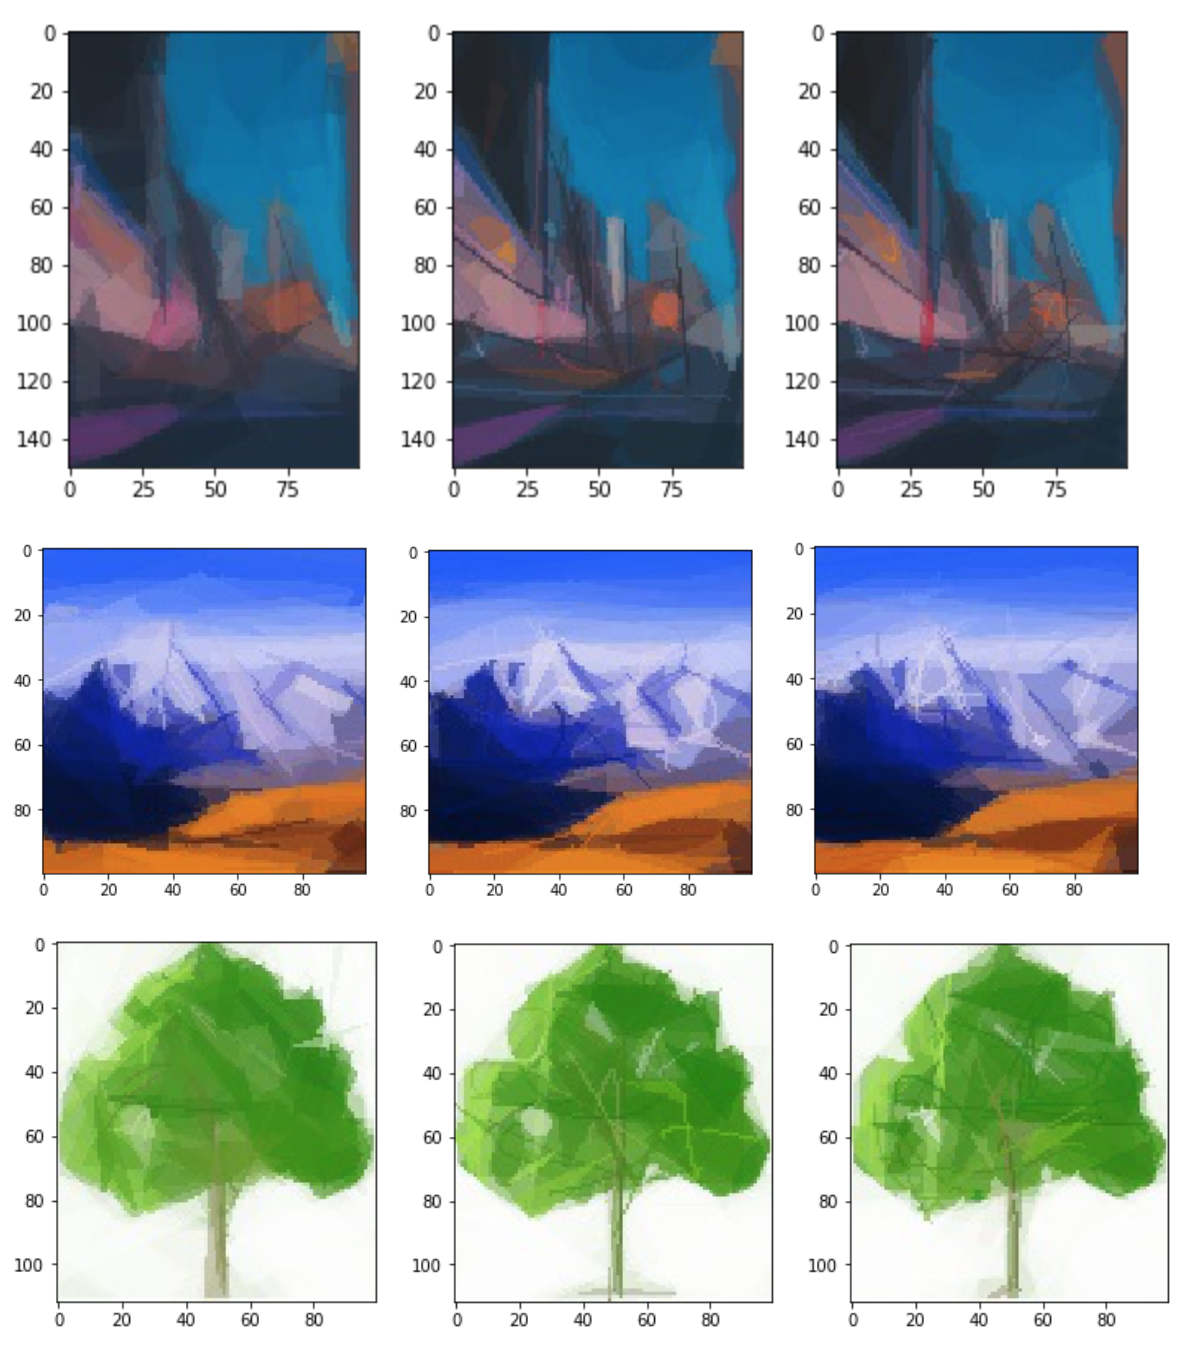

## Najlepsze obrazki n = 10
W kolejności random, simple, natural

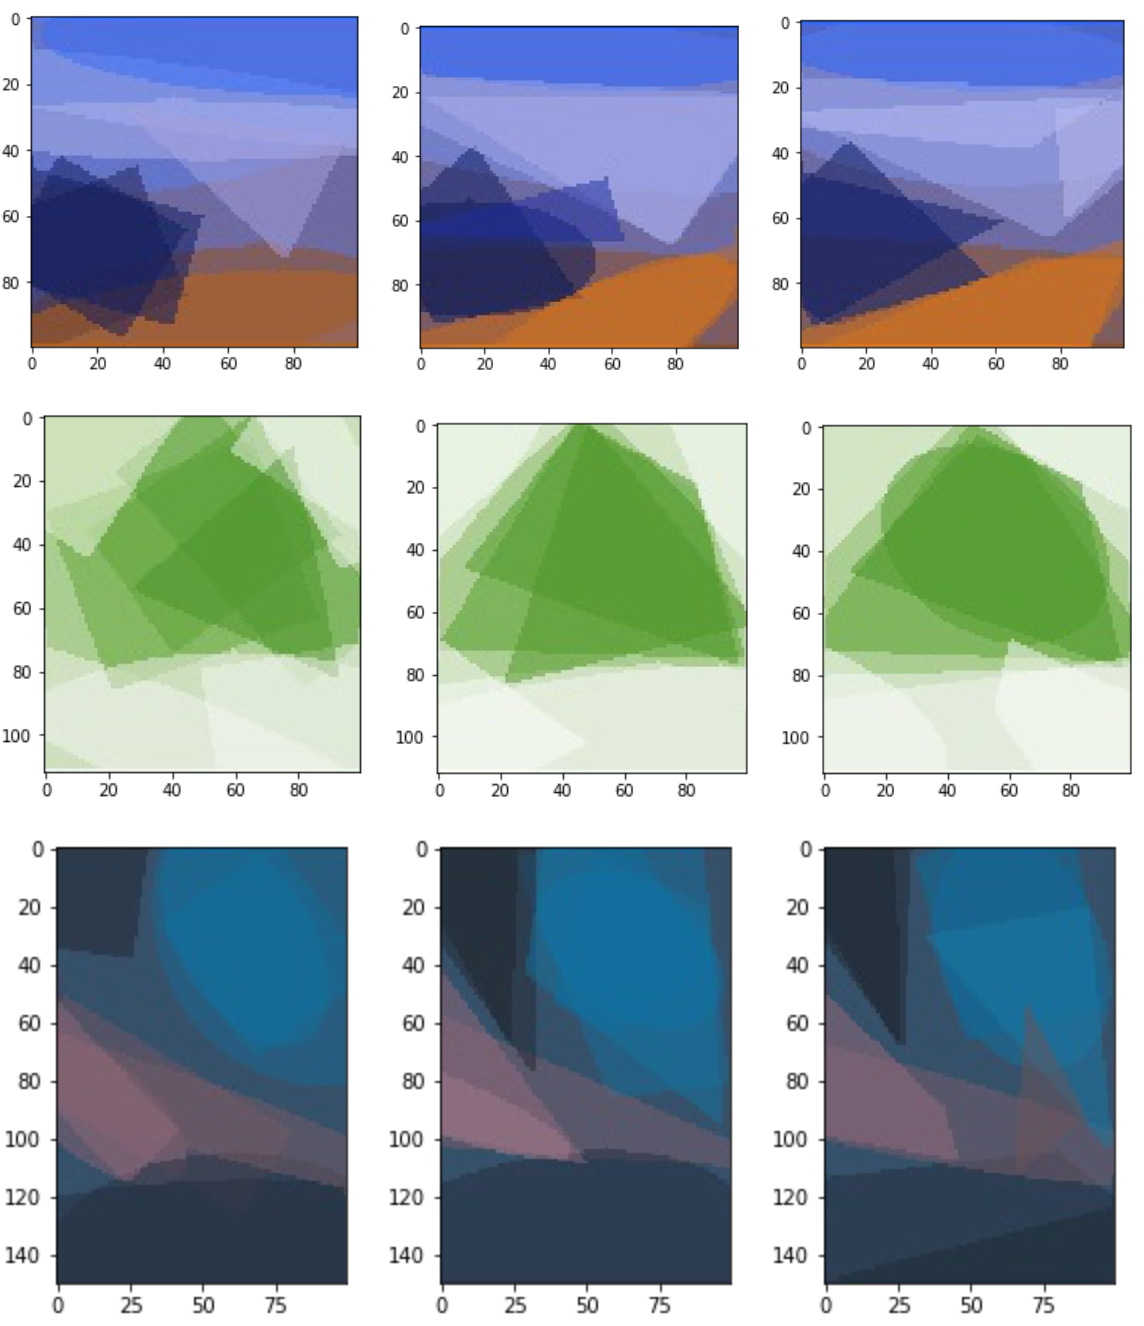

## Wnioski

Simple wydaje się działać trochę lepiej niż natural :(

# Parametry random, sample, step
random - ilość kształtów losowanych przed rozpoczęciem evolution strategies   
sample - ilość sampli w każdym kroku evolution strategies  
step - ilość kroków evolution strategies

In [2]:
parameters = [
    (100, 10, 100),
    (100, 20, 50),
    (100, 25, 40),
    (100, 40, 25),
    (100, 50, 20),
    (100, 100, 10),
    (100, 125, 8),
    (100, 8, 125),
    (100, 5, 200),
    (100, 200, 5)
]

In [4]:
ROOT_DATA = '/Users/mchrusci/uj/shaper/data'
ROOT_RESULT = '/Users/mchrusci/uj/shaper/result/evolution-strategies-experiments/step'
data = [
    (
        os.path.join(ROOT_DATA, 'mountains/mountains.jpg'), 
        os.path.join(ROOT_RESULT, 'mountains/mountains-random-{}-sample-{}-step-{}-%d.jpg')
    ), (
        os.path.join(ROOT_DATA, 'city.jpg'), 
        os.path.join(ROOT_RESULT, 'city/city-random-{}-sample-{}-step-{}-%d.jpg')
    ), (
        os.path.join(ROOT_DATA, 'tree/tree-small.jpg'), 
        os.path.join(ROOT_RESULT, 'tree/tree-random-{}-sample-{}-step-{}-%d.jpg')
    )
]
data

[('/Users/mchrusci/uj/shaper/data/mountains/mountains.jpg',
  '/Users/mchrusci/uj/shaper/result/evolution-strategies-experiments/step/mountains/mountains-random-{}-sample-{}-step-{}-%d.jpg'),
 ('/Users/mchrusci/uj/shaper/data/city.jpg',
  '/Users/mchrusci/uj/shaper/result/evolution-strategies-experiments/step/city/city-random-{}-sample-{}-step-{}-%d.jpg'),
 ('/Users/mchrusci/uj/shaper/data/tree/tree-small.jpg',
  '/Users/mchrusci/uj/shaper/result/evolution-strategies-experiments/step/tree/tree-random-{}-sample-{}-step-{}-%d.jpg')]

In [41]:
N = 100

for i, o in tqdm(data):
    for random, sample, step in tqdm(parameters):
        cmd = f'python ../main.py --input {i} --output {o.format(random, sample, step)} --n {N} --random {random} --sample {sample} --step {step}'
        os.system(cmd)

In [54]:
CSV = ROOT_RESULT + '-results.csv'
df = pd.read_csv(CSV)

In [51]:
df = df[['n', 'sample', 'mse']]

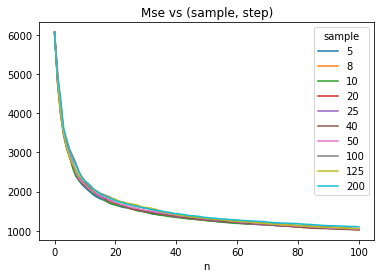

In [48]:
df.groupby(['n', 'sample']).mean()['mse'].unstack().plot(title='Mse vs (sample, step)')

Stosunek sample do step wydaje się nie mieć znaczącego wpływu na loss

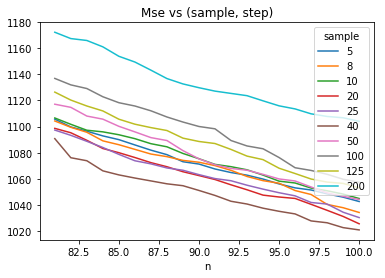

In [56]:
df[df['n'] > 80].groupby(['n', 'sample']).mean()['mse'].unstack().plot(title='Mse vs (sample, step)')

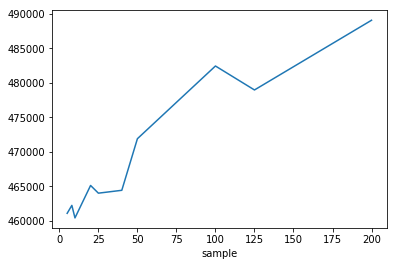

In [55]:
df.groupby(['sample']).sum()['mse'].plot()

In [60]:
# najlepsza wartość sample
df.groupby(['sample']).sum()['mse'].idxmin()

10

In [61]:
# najgorsza wartość sample
df.groupby(['sample']).sum()['mse'].idxmax()

200

Czyli najmniejszy loss (sumując po wszystkich n) wyszedł dla pary sample = 10, step = 100, najgorszy dla sample = 200, step = 5   
Porównanie obrazków dla najlepszych i najgorszych parametrów:

In [52]:
def show_for_sample(df, sample, idx, n=100):
    path = df[(df['sample'] == sample) & (df['n'] == n)]['output'].iloc[idx]
    img = imread(path)
    plt.imshow(img)

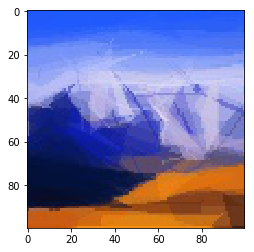

In [55]:
# najlepszy
show_for_sample(df, 10, 0)

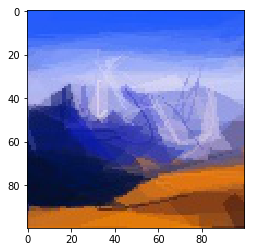

In [56]:
# najgorszy
show_for_sample(df, 200, 0)

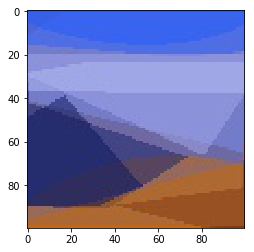

In [57]:
# najlepszy
show_for_sample(df, 10, 0, n=10)

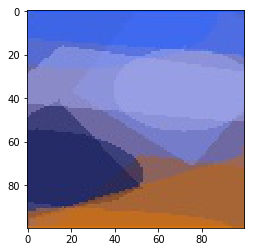

In [58]:
# najgorszy
show_for_sample(df, 200, 0, n=10)

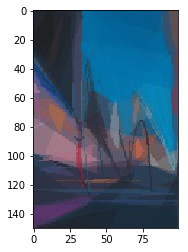

In [76]:
# najlepszy
show_for_sample(df, 10, 1)

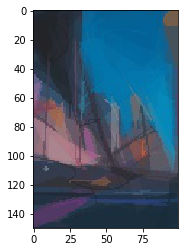

In [77]:
# najgorszy
show_for_sample(df, 200, 1)

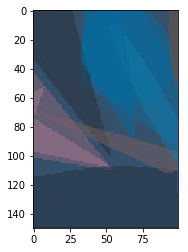

In [59]:
# najlepszy
show_for_sample(df, 10, 1, n=10)

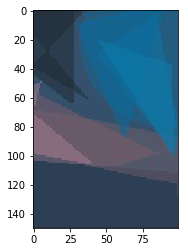

In [60]:
# najgorszy
show_for_sample(df, 200, 1, n=10)

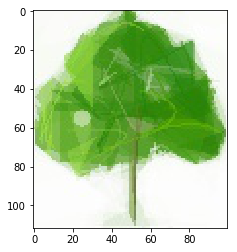

In [78]:
# najlepszy
show_for_sample(df, 10, 2)

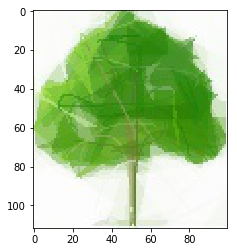

In [80]:
# najgorszy
show_for_sample(df, 200, 2)

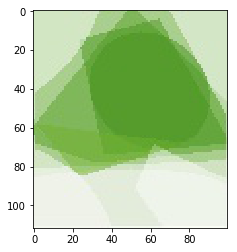

In [61]:
# najlepszy
show_for_sample(df, 10, 2, n=10)

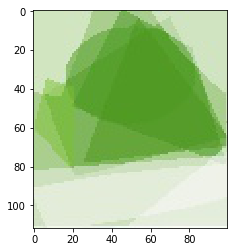

In [62]:
# najgorszy
show_for_sample(df, 200, 2, n=10)

Różnice wizualne pomiędzy najlepszym a najgorszym obrazkiem ponownie są dosyc subtelne.

# Score vs zwiększanie ilości kroków algorytmu

In [5]:
parameters = [
    (1, 10),
    (2, 20),
    (3, 30),
    (4, 40),
    (5, 50),
    (6, 60),
    (7, 70),
    (8, 80),
    (9, 90),
    (10, 100),
    (11, 110),
    (12, 120),
    (13, 130),
    (14, 140),
    (15, 150),
    (16, 160),
    (17, 170),
    (18, 180),
    (19, 190),
    (20, 200),
]

In [8]:
N = 100

for i, o in tqdm(data):
    for sample, step in tqdm(parameters):
        cmd = f'python ../main.py --input {i} --output {o.format(100, sample, step)} --n {N} --sample {sample} --step {step}'
        os.system(cmd)

In [65]:
CSV = '/Users/mchrusci/uj/shaper/result/evolution-strategies-experiments/growing-step-results.csv'
df = pd.read_csv(CSV)

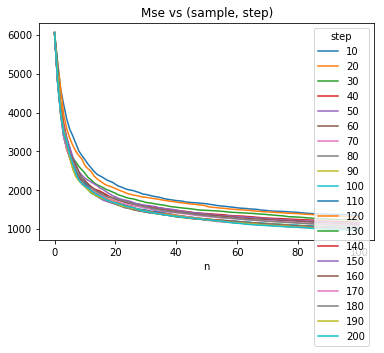

In [14]:
df[['n', 'step', 'mse']].groupby(['n', 'step']).mean()['mse'].unstack().plot(title='Mse vs (sample, step)')

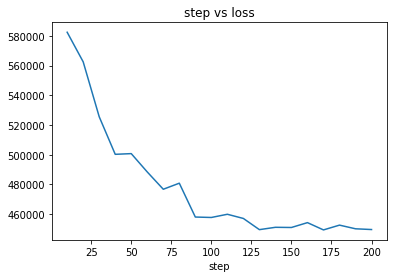

In [18]:
df[['n', 'step', 'mse']].groupby(['step']).sum()['mse'].plot(title='step vs loss')

Czyli mniej więcej przy step = 100 się wypłaszcza - czyli więcej kroków nie znajduje już zazwyczaj żadnego dużo lepszego kształtu do narysowania niż ten, który już został znaleziony.

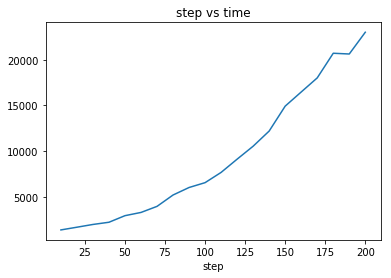

In [17]:
df[['n', 'step', 'time']].groupby(['step']).sum()['time'].plot(title='step vs time')

Czas działania algorytmu rośnie liniowo (a nawet trochę bardziej) wraz ze wzrostem ilości kroków, więc raczej nie opłaca się wybierać większej ilości kroków niż ~100, ponieważ zysk w mse będzie stosunkowo mały. Jednak jak widać niżej, jest różnica (głównie jeżeli chodzi o szczegóły) pomiędzy step = 100 a step = 200.

In [91]:
def show_for_step(df, step, idx, title, n=100):
    path = df[(df['step'] == step) & (df['n'] == n)]['output'].iloc[idx]
    img = imread(path)
    plt.imshow(img)
    plt.title(title)
    plt.show()

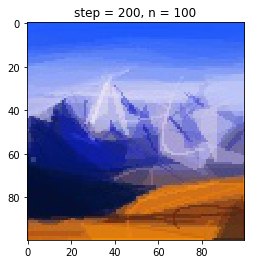

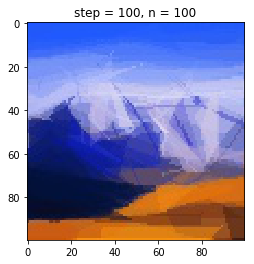

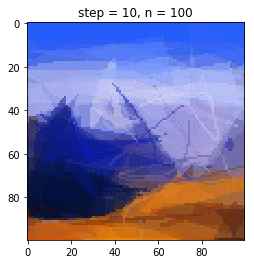

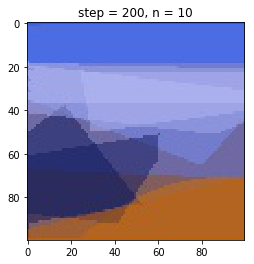

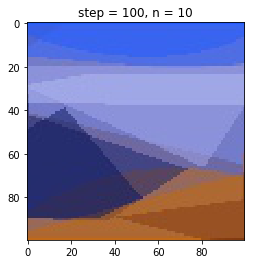

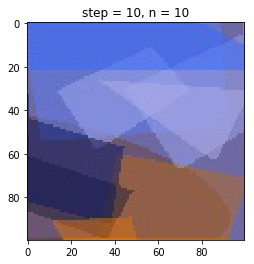

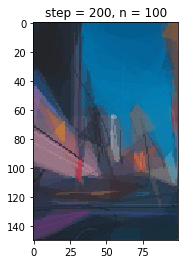

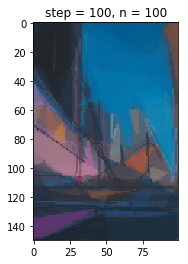

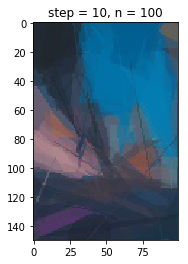

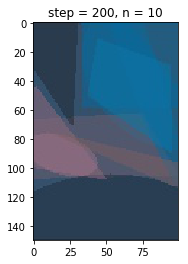

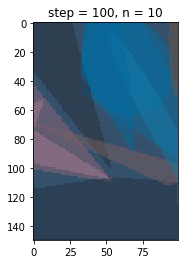

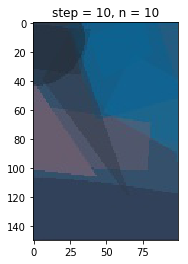

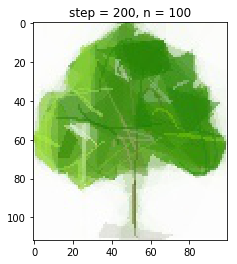

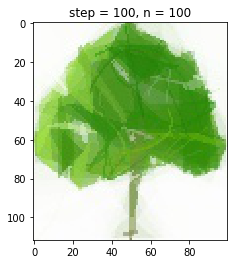

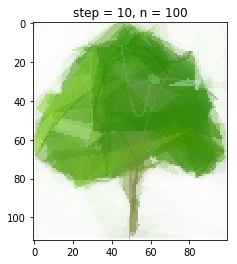

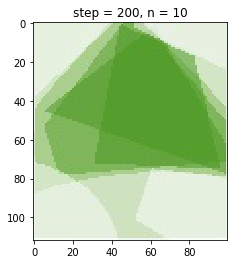

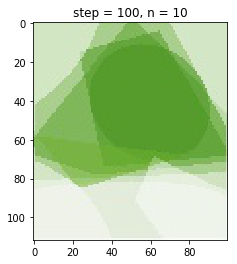

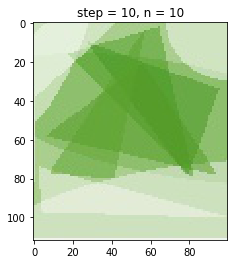

In [92]:
for img in range(3):
    for n in [100, 10]:
        for step in [200, 100, 10]:
            show_for_step(df, step, img, f'step = {step}, n = {n}', n)